# Wavelet analysis  of net load

*notebook split out of [Input_Markov_model.ipynb](Input_Markov_model.ipynb)*

$$P_{nl}= P_{load} - P_{sun}$$

## Load testcase data — training set


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
P_pvp = 3 # kW

In [4]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)
dt = 0.5 # hours

sl = slice('2011-10-29','2011-11-28')
df = df[sl]

Compute "net load": $P_{nl}= P_{load} - P_{sun}$

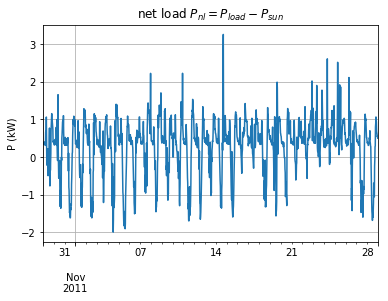

In [5]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

P_nl = P_load - P_sun
ax = P_nl.plot()
ax.set(ylabel='P (kW)', title="net load $P_{nl}= P_{load} - P_{sun}$")
plt.grid()

## Daily pattern of the mean

In [6]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

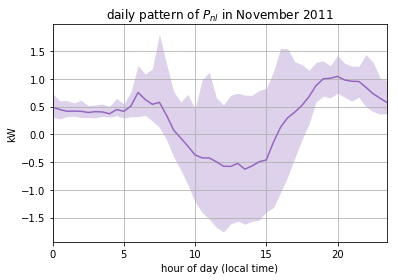

In [8]:
c = 'tab:purple'
P_byhod = P_nl.groupby(hod)
P_dm = P_byhod.mean()

ax = P_dm.plot(c=c)
ax.fill_between(P_dm.index, P_byhod.quantile(.05), P_byhod.quantile(.95),
                alpha=0.3, color=c, lw=0)
ax.set(
    title='daily pattern of $P_{nl}$ in November 2011',
    ylabel='kW',
    xlabel='hour of day (local time)'
)
ax.grid()


## Wavelet decomposition

In [9]:
import pywt

In [11]:
#wavelet = 'haar'
wavelet='db2'
#wavelet='db3'
mode = 'periodization'
#mode='periodic' # same as periodization for haar or db1, but not for db2

wcoeffs = pywt.wavedec(P_dm, wavelet, mode=mode)
cAn = wcoeffs[0]
cDn = wcoeffs[1:]

level = len(wcoeffs) - 1
print('decompostion level: %d' % level)

if level==5:
    cA5, cD5, cD4, cD3, cD2, cD1 = wcoeffs
    print(len(cA5), len(cD5), len(cD4), len(cD3), len(cD2), len(cD1))

if level==4:
    cA4, cD4, cD3, cD2, cD1 = wcoeffs
    print(len(cA4), len(cD4), len(cD3), len(cD2), len(cD1))

if level==3:
    cA3, cD3, cD2, cD1 = wcoeffs
    print(len(cA3), len(cD3), len(cD2), len(cD1))
    
print('total nb of coeffs: %d' % sum([len(c) for c in wcoeffs]))

decompostion level: 4
3 3 6 12 24
total nb of coeffs: 48


In [13]:
k1 = np.arange(24)*2 + 1
k2 = np.arange(12)*4 + 2
k3 = np.arange(6)*8 + 4
k4 = np.arange(3)*16 + 8
k5 = np.arange(2)*32 + 16

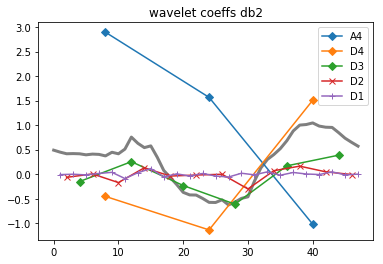

In [14]:
plt.plot(P_dm.values, color='k', lw=3, alpha=0.5)

if level==5:
    plt.plot(k5, cA5, 's-', label='A5')
    plt.plot(k5, cD5, 'D-', label='D5')
    plt.plot(k4, cD4, 'D-', label='D4')

if level==4:
    plt.plot(k4, cA4, 'D-', label='A4')
    plt.plot(k4, cD4, 'D-', label='D4')

if level==3:
    plt.plot(k3, cA3, 'D-', label='A4')

plt.plot(k3, cD3, 'D-', label='D3')
plt.plot(k2, cD2, 'x-', label='D2')
plt.plot(k1, cD1, '+-', label='D1')

plt.title('wavelet coeffs %s' % wavelet)
plt.legend();

### Reconstruction with selected coefficients

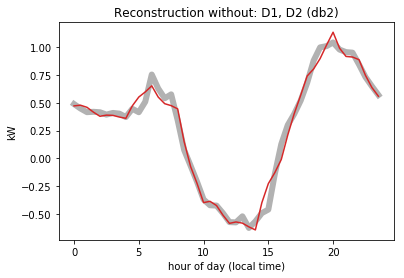

In [15]:
wcoeffs_filt = [c.copy() for c in wcoeffs]
select = np.ones(len(wcoeffs))
rem_coeff = []
select[-1] = 0; rem_coeff.append('D1')
select[-2] = 0; rem_coeff.append('D2')
#select[-3] = 0 ; rem_coeff.append('D3')
#select[-4] = 0 ; rem_coeff.append('D4')
#select[-5] = 0 ; rem_coeff.append('D5')
#select[0] = 0 ; rem_coeff.append('A5')

for k, s in enumerate(select):
    wcoeffs_filt[k] *= s

plt.plot(P_dm, color='k', lw=6, alpha=0.3)
plt.plot(P_dm.index, pywt.waverec(wcoeffs_filt, wavelet, mode), color='tab:red');
ax = plt.gca()
ax.set(
    title='Reconstruction without: {} ({})'.format(', '.join(rem_coeff), wavelet),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

#### Progressive reconstruction


Failed attempt with `pywt.upcoef`: 
`pywt.upcoef` seems to not work with `periodization` `mode` (for wavelet `db2`. With haar it is fine though). Using waverec of idwt instead

In [16]:
# Not working with db2
rec_levels = [
    pywt.upcoef('a', cAn, wavelet, level=level, take=48)+
    pywt.upcoef('d', cDn[0], wavelet, level=level, take=48)
]

for k in range(1, level):
    rec_levels.append(
    pywt.upcoef('d', cDn[k], wavelet, level=level-k)[:48]
    )

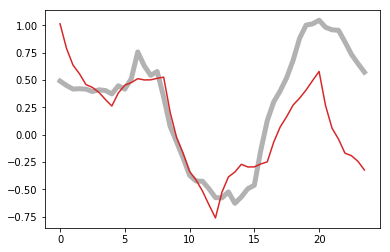

In [17]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, rec_levels[0], color='tab:red')

Second failed attempt with idwt: it gives only a *single level* reconstruction

In [19]:
rec_levels = [
    pywt.idwt(cAn, cDn[0], wavelet, mode)
]

for k in range(1, level):
    rec_levels.append(
        pywt.idwt(None, cDn[k], wavelet, mode)
    )

In [20]:
len(rec_levels[0])

6

Reconstruction function

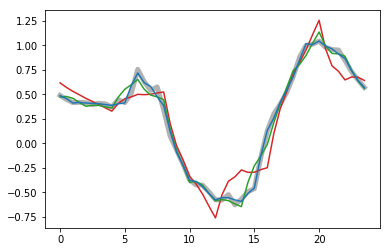

In [23]:
def recons_level(wcoeffs, l):
    '''reconstruct signal down to level `l`'''
    wcoeffs_r = [c.copy() for c in wcoeffs]
    select = np.ones(len(wcoeffs))
    assert l <= level
    if l>=2:
        select[-l+1:] = 0
    elif l==1:
        pass

    for k, s in enumerate(select):
        wcoeffs_r[k] *= s
        
    return pywt.waverec(wcoeffs_r, wavelet, mode)

plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, recons_level(wcoeffs, 4), color='tab:red')
plt.plot(P_dm.index, recons_level(wcoeffs, 3), color='tab:green')
plt.plot(P_dm.index, recons_level(wcoeffs, 2), color='tab:blue');

In [24]:
def detail_level(wcoeffs, l):
    '''reconstruct the detail signal at level `l`'''
    wcoeffs_d = [c.copy() for c in wcoeffs]
    select = np.zeros(len(wcoeffs))
    assert 0 <= l <= level
    select[1+level-l] = 1

    for k, s in enumerate(select):
        wcoeffs_d[k] *= s
        
    return pywt.waverec(wcoeffs_d, wavelet, mode)

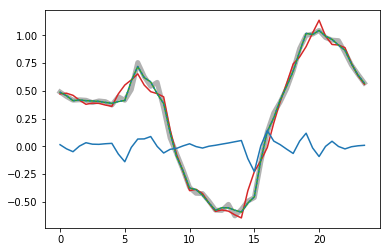

In [25]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, recons_level(wcoeffs, 3), color='tab:red')
plt.plot(P_dm.index, recons_level(wcoeffs, 2), color='tab:green')
plt.plot(P_dm.index, detail_level(wcoeffs, 2), color='tab:blue')
plt.plot(P_dm.index, detail_level(wcoeffs, 2) + recons_level(wcoeffs, 3), ':')

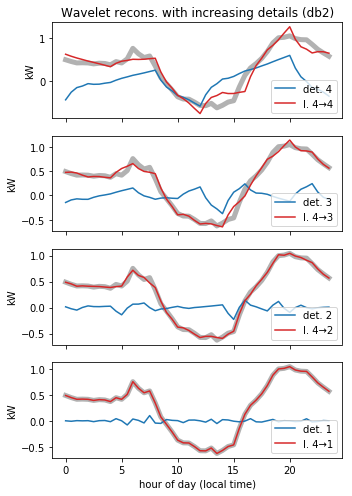

In [26]:
fig, ax = plt.subplots(level, sharex=True, figsize=(5,7))

for k in range(level):
    ax[k].plot(P_dm, color='k', lw=5, alpha=0.3)
    l = level-k
    ax[k].plot(P_dm.index, detail_level(wcoeffs, l), label='det. %d' % l)
    ax[k].plot(P_dm.index, recons_level(wcoeffs, l), color='tab:red', label='l. %d→%d' % (level, l))
    ax[k].legend(loc='lower right')
    ax[k].set_ylabel('kW')
    
ax[0].set(
    title='Wavelet recons. with increasing details (%s)' % wavelet,
)
ax[-1].set(
    xlabel='hour of day (local time)'
)
fig.tight_layout()

fname = 'wavelet_recons_%s.png' % wavelet
fig.savefig(fname, dpi=150, bbox_inches='tight')

## Wavelet-based basis

objective: create base vectors for a linear regression

Starts from the null coefficients (from a zero signal), to get the proper coeff structure

In [62]:
wavelet='db2'
mode = 'periodization'
#mode='periodic' # same as periodization for haar or db1, but not for db2

wcoeffs0 = pywt.wavedec(np.zeros_like(P_dm), wavelet, mode=mode)
wcoeffs0

[array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])]

Structure of the coefficients

In [63]:
level = len(wcoeffs) - 1
level

4

In [64]:
lens = [len(c) for c in wcoeffs0]
lens

[3, 3, 6, 12, 24]

In [65]:
sum(lens)

48

In [66]:
c_names = ['A4', 'D4', 'D3', 'D2', 'D1']
assert len(c_names) == level+1

In [73]:
b_names = []

for k, nc in enumerate(lens):
    for n in range(nc):
        b_names.append(c_names[k] + '_' + str(n+1))

Build the basis by iteratively setting one coeff to 1.0

In [68]:
basis = []
indices = [] # for the identification of the base vector

for k, cAD in enumerate(wcoeffs0):
    for n in range(len(cAD)):
        wcoeffs_kn = [c.copy() for c in wcoeffs0]
        wcoeffs_kn[k][n] = 1
        
        basis.append(
            pywt.waverec(wcoeffs_kn, wavelet, mode)
        )
        indices.append((k,n))

### Look at the base vectors

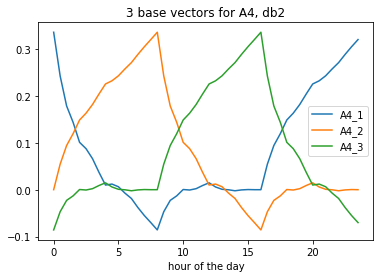

In [74]:
def show_basis(k):
    plt.plot(P_dm.index, basis[k], label=b_names[k])
    plt.title('Base vector {} {}, {}'.format(k, indices[k], wavelet))
    plt.xlabel('hour of the day')

show_basis(0)
show_basis(1)
show_basis(2)
plt.legend()
plt.title('%d base vectors for A4, %s' % (len(wcoeffs0[0]), wavelet));

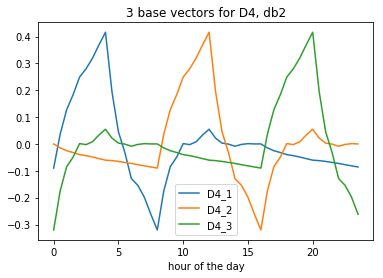

In [75]:
show_basis(3)
show_basis(4)
show_basis(5)
plt.legend()
plt.title('%d base vectors for D4, %s' % (len(wcoeffs0[-4]), wavelet));

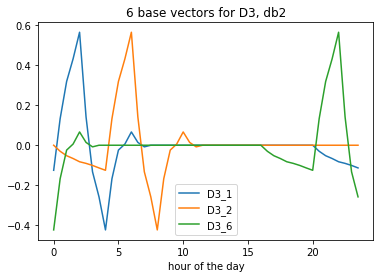

In [76]:
show_basis(6)
show_basis(7)
show_basis(11)
plt.legend()
plt.title('%d base vectors for D3, %s' % (len(wcoeffs0[-3]), wavelet));

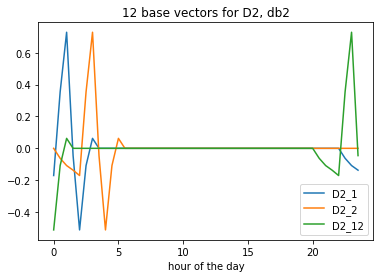

In [77]:
show_basis(12)
show_basis(13)
show_basis(23)
plt.legend()
plt.title('%d base vectors for D2, %s' % (len(wcoeffs0[-2]), wavelet));

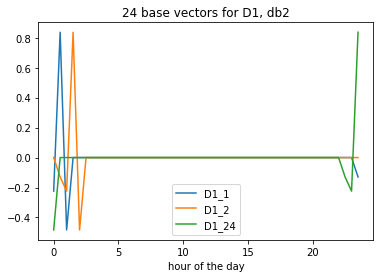

In [78]:
show_basis(24)
show_basis(25)
show_basis(47)
plt.legend()
plt.title('%d base vectors for D1, %s' % (len(wcoeffs0[-1]), wavelet));

Convert to numpy array where:

* time is axis 0
* basis index is axis 1

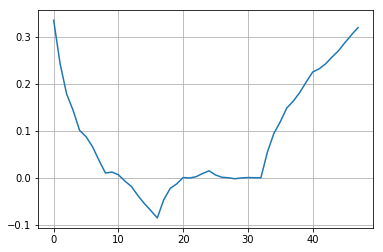

In [79]:
basis = np.array(basis).T
plt.plot(basis[:,0])
plt.grid()

Substract the mean, to avoid problems in regression (colinearity with the intercept)

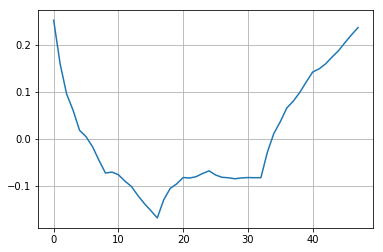

In [80]:
basis_c = (basis - basis.mean(axis=0))
plt.plot(basis_c[:,0])
plt.grid()

### Save the basis

In [81]:
fname = 'basis_{}_{}.csv'.format(wavelet, '-'.join(map(str,lens)))
fname

'basis_db2_3-3-6-12-24.csv'

In [83]:
np.savetxt(fname, basis_c, delimiter=',', header=','.join(b_names), comments='')

In [86]:
!head $fname -n2

A4_1,A4_2,A4_3,D4_1,D4_2,D4_3,D3_1,D3_2,D3_3,D3_4,D3_5,D3_6,D2_1,D2_2,D2_3,D2_4,D2_5,D2_6,D2_7,D2_8,D2_9,D2_10,D2_11,D2_12,D1_1,D1_2,D1_3,D1_4,D1_5,D1_6,D1_7,D1_8,D1_9,D1_10,D1_11,D1_12,D1_13,D1_14,D1_15,D1_16,D1_17,D1_18,D1_19,D1_20,D1_21,D1_22,D1_23,D1_24
2.524538706786444986e-01,-8.333333333333335646e-02,-1.691205373453111283e-01,-8.997391014371411422e-02,-8.447741927282889036e-19,-3.201622040119778134e-01,-1.250751254186969752e-01,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.225925490014673658e-01,-1.707531754730548523e-01,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-4.625929269271485328e-18,-5.122595264191645015e-01,-2.241438680420133889e-01,-1.156482317317871332e-18,-1.156482317317871332e-18,-1.156482317317871332e-18,-1.156482317317

## Linear regression application

Quick check of the basis usability for the fitting the mean daily pattern

See [Input_Markov_model.ipynb](Input_Markov_model.ipynb) for more regression (Ridge, Lasso)

In [87]:
from sklearn import linear_model

In [88]:
ndays = len(P_nl)/48
assert ndays == round(ndays)
ndays = int(ndays)

X = np.tile(basis_c, (ndays, 1))
X.shape

(1488, 48)

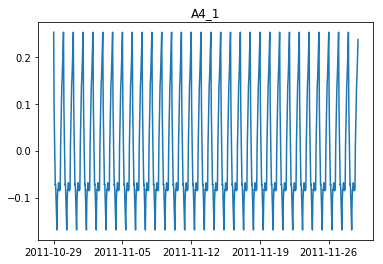

In [90]:
plt.plot(P_nl.index, X[:,0])
plt.title(b_names[0]);

In [91]:
reg = linear_model.LinearRegression()
reg.fit(X, P_nl)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Intercept is ok (because base vectors are centered)

In [92]:
reg.intercept_

0.2866806761786601

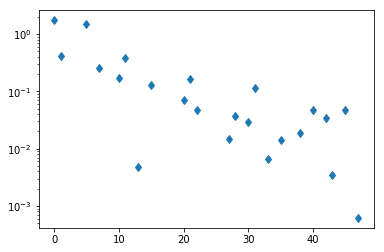

In [93]:
plt.semilogy(reg.coef_, 'd')

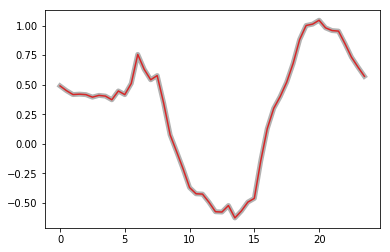

In [94]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, reg.predict(X[:48,:]), color='tab:red')

Observation: we get **perfect reconstruction** of the mean pattern.

See [Input_Markov_model.ipynb](Input_Markov_model.ipynb) for more regression (Ridge, Lasso)